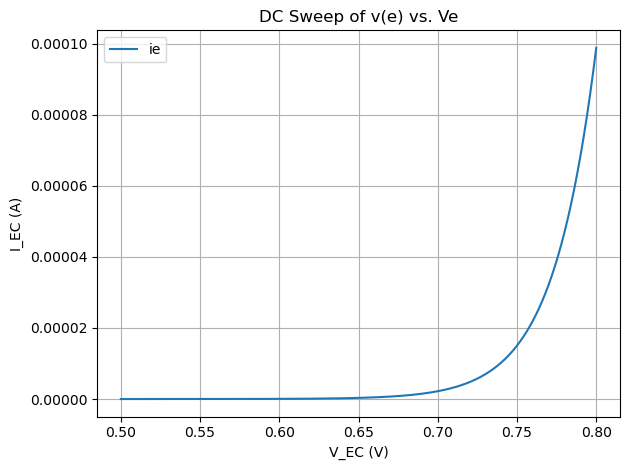

In [210]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from pygmid import Lookup as lk

#messages
info = '>>  [info]'

#file import
nfet = lk('../nfet_03v3.mat')
pfet = lk('../pfet_03v3.mat')
pnp = np.loadtxt("../pnp_test_unit.txt", skiprows=1)  # First row is headers
VDS1 = 0.6 #only used when assuming saturation of a device

bjt_voltage = pnp[:, 0]  
bjt_current = -2*pnp[:, 1] # Use two unit elements in the first branch

np.all(np.diff(bjt_voltage) > 0) #verify x value increasing
np.all(np.diff(bjt_current) > 0) #verify y value increasing

plt.plot(bjt_voltage, bjt_current, label="ie")
plt.xlabel("V_EC (V)")
plt.ylabel("I_EC (A)")
plt.title("DC Sweep of v(e) vs. Ve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [211]:
#Constants
vgo = 1.17 #silicon bandgap, roughly
kb = 1.380649 * (10**-23)
qc = 1.602* (10**-19)
temp = 273.15 + 27
vt = kb*temp/qc

#Parameters and Guesses
gm_id_p = 6
gm_id_n = 8
pnp_ratio = 4
l_n = 1
l_p = 1

#Power: note bias current will be specified @ 27C
i_total_limit = 75e-6
i_bias = 10e-6
i_ref = 10e-6
i_buffer = 25e-6 #IDEALLY FIND A WAY TO GET THIS VALUE DIRECTLY FROM THE LATEST OTA SIMULATION

#Supply
vdd_min = 3.2
vdd_max = 3.4
vdd_pass = True


In [212]:
# Calculate R at specified Temp to provide target bias current
R1 = (vt * np.log(pnp_ratio)) / i_bias
print('R1 =', round(R1/1e3, 2), 'kOhm')

#Biasing Characteristics
i_total = (3*i_bias) + i_buffer + i_ref
print('total current =', round(i_total/1e-6, 4), 'uA')
if i_total < i_total_limit:
    print(info, 'power consumption target is met!')
    vdd_pass = True
else:
    print(info, 'power consumption target is NOT met!')
    vdd_pass = False

#Parasitic pnp expected vbe
vbe1 = np.interp(i_bias, bjt_current, bjt_voltage)
vbe23 = np.interp(i_bias, pnp_ratio*bjt_current, bjt_voltage)
print('vbe1 =', round(vbe1/1e-3, 4), 'mV')
print('vbe23 =', round(vbe23/1e-3, 4), 'mV')

R2 = (vgo - vbe23)/i_bias

print("R2 =", round(R2/1e3, 2), 'kOhm')



R1 = 3.59 kOhm
total current = 65.0 uA
>>  [info] power consumption target is met!
vbe1 = 739.3645 mV
vbe23 = 703.326 mV
R2 = 46.67 kOhm


In [213]:
# Cascoded current sources
vds_n = 2*(2/gm_id_n)
vds_p = 2*(2/gm_id_p) # you need two vds per cascode for saturation

print('PMOS Cascode Saturation VDS =', round(vds_p, 4), 'V')
print('NMOS Cascode Saturation VDS =', round(vds_n, 4), 'V')

#Let cascoded devices be identical
gm_n = gm_id_n * i_bias
gm_p = gm_id_p * i_bias
print('gm_n =', round(gm_n/1e-3, 4), 'mS')
print('gm_p =', round(gm_p/1e-3, 4), 'mS')

#Output Resistance of Cascodes: SATURATION ASSUMED
gm_gds_n = nfet.lookup('GM_GDS', GM_ID=gm_id_n, L=l_n, VDS=VDS1, VSB=0)
gm_gds_p = pfet.lookup('GM_GDS', GM_ID=gm_id_p, L=l_p, VDS=VDS1, VSB=0)


#output resistance is boosted in cascode to gmro1ro2 + ro1 + ro2 = (gm/gds)(gm/gds)/gm + 2*(gm/gds)/gm
ro_n = (gm_gds_n ** 2)/gm_n + 2*(gm_gds_n/gm_n)
ro_p = (gm_gds_p ** 2)/gm_p + 2*(gm_gds_p/gm_p)

print(info, "The following assume saturation:")
print('ro_n =', round(ro_n/1e3,), 'kOhm')
print('ro_p =', round(ro_p/1e3,), 'kOhm')


PMOS Cascode Saturation VDS = 0.6667 V
NMOS Cascode Saturation VDS = 0.5 V
gm_n = 0.08 mS
gm_p = 0.06 mS
>>  [info] The following assume saturation:
ro_n = 601173 kOhm
ro_p = 434410 kOhm


In [214]:
vdd_min_branch1 = vds_p+vds_n+vbe1
print("Required VDD from branch 1 =", round(vdd_min_branch1, 3), 'V')

if vdd_min_branch1 < vdd_min:
    print(info, 'Supply headroom is sufficient for the first branch!')
else:
    print(info, 'VDD is NOT sufficient to sustain target overdrive!')


vdd_min_branch2 = vds_p+vds_n+vbe23+i_bias*R1
print("Required VDD from branch 2 =", round(vdd_min_branch2, 3) )

if vdd_min_branch2 < vdd_min:
    print(info, 'Supply headroom is sufficient for the second branch!')
    vdd_pass = True
else:
    print(info, 'VDD is NOT sufficient to sustain target overdrive in the second branch!')
    vdd_pass = False

vdd_min_branch3 = vds_p +vds_n+vbe23+i_bias*R2
print("Required VDD from branch 3 =", round(vdd_min_branch3, 3) )

if vdd_min_branch3 < vdd_min:
    print(info, 'Supply headroom is sufficient for the final branch!')
    vdd_pass = True
else:
    print(info, 'VDD is NOT sufficient to sustain target overdrive in the final branch!')
    vdd_pass = False

if vdd_pass:
    print(info, 'VDD Passes all checks!')
else:
    print(info, 'VDD FAILS one or more verifications')


Required VDD from branch 1 = 1.906 V
>>  [info] Supply headroom is sufficient for the first branch!
Required VDD from branch 2 = 1.906
>>  [info] Supply headroom is sufficient for the second branch!
Required VDD from branch 3 = 2.337
>>  [info] Supply headroom is sufficient for the final branch!
>>  [info] VDD Passes all checks!


In [215]:
id_w_n = nfet.lookup('ID_W', GM_ID=gm_id_n, L=l_n, VDS=VDS1, VSB=0)
w_n = i_bias / id_w_n
w_n_round = max(round(w_n*2)/2, 0.5)
print('M_N W =', round(w_n, 2), 'um, rounded W =', w_n_round, 'um')


id_w_p = pfet.lookup('ID_W', GM_ID=gm_id_p, L=l_p, VDS=VDS1, VSB=0)
w_p = i_bias / id_w_p
w_p_round = max(round(w_p*2)/2, 0.5)
print('M_P W =', round(w_p, 2), 'um, rounded W =', w_p_round, 'um')


M_N W = 2.75 um, rounded W = 2.5 um
M_P W = 6.58 um, rounded W = 6.5 um


In the actual design, I ended up roughly doubling these widths to improve matching, and I found that the accuracy (presumably from the increased gm?) increased over the specified temperature range.